# Analyzing the NYC Subway Dataset

## by Rica Enriquez, June 1, 2015

<p>In this project, the NYC Subway data is analyzed to figure out if more people ride the subway when it is raining versus when it is not raining. The improved-dataset is used for the analysis.</p>

In [1]:
import scipy.stats
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from datetime import datetime

dt_par = lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
input_filename = "improved-dataset/turnstile_weather_v2.csv"
turnstile_weather = pd.read_csv(input_filename, parse_dates=['datetime'], date_parser=dt_par)

#All hourly entries
hourly_entries = turnstile_weather[['ENTRIESn_hourly']]

# Get hourly entry samples from dataframe
rainy = turnstile_weather[turnstile_weather.rain == 1].ENTRIESn_hourly
dry = turnstile_weather[turnstile_weather.rain == 0].ENTRIESn_hourly

## Section 0.	References

<p>http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.mannwhitneyu.html</p>
<p>https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php</p>
<p>http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.html</p>
<p>http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/#hetero-header</p>

## Section 1.	Statistical Test

### 1.1. Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

<p>The Mann–Whitney U test is used to analyze the NYC subway data since it is a nonparametric test. With this test the underlying distribution is not assumed. The two inputs are 'ENTRIESn_hourly' for 1) rainy days and 2) dry days.</p>

<p>The null hypothesis for this test states that the sample data from rainy days and dry days come from the same population. In other words, data for rainy days should not result in a statistically different mean from the sample data for dry days.</p>
    
<p>A two-tail P value, which is twice the output of the scipy.stats.mannwhitneyu implementation, is used. A two-tail P value is appropriate since the null hypothesis does not assume if a sample has a higher or lower mean hourly entry than the other sample.</p>

<p>A critical P value of 0.05 is used.</p>

In [2]:
# Run Mann-Whitney U Test
U,p = scipy.stats.mannwhitneyu(rainy,dry)

#Set critical P value
p_critical = 0.05

### 1.2. Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

<p>A histogram of the NYC subway ridership (Figure 1 in Section 3) helps show the distribution of the two samples. Both samples show positive skewed distributions. Thus, a nonparametric test that does not assume normal distributions for the samples, e.g., the Mann-Whitney U test, is appropriate. To apply this test, the samples need to fulfill the following assumptions:
<ul>
<li>Assumption 1: The dependent variable should be ordinal or continuous. The variable 'ENTRIESn_hourly' is continuous.</li>
<li>Assumption 2: The independent variable should consist of two categorical, independent groups. The independent groups are days with rain and days without rain.</li>
<li>Assumption 3: The observations should be independent, which means that there is no relationship between the observations in each group or between the groups themselves. Each observation in the dataset is independent since they are entries/hour at a specific unit at a given hour.</li>
<li>Assumption 4: The two distributions for both groups of the independent variable should have similar shapes. Figure 1 in Section 3 shows that the distributions are similar in shape.</li></ul></p>

### 1.3. What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [3]:
# The Mann-Whitney U Test produces a one-tail P value
# Multiply it by 2.0 to get the two-tail P value and compare it to the critical P value
if p*2. < p_critical:
    print 'The P value is less than the critical P value. Therefore, we reject the null', \
          'hypothesis. The samples from rainy days and dry days are statistically different', \
          'and are likely to come from different populations.'
else:
    print 'The P value is more than or equal to the critical P value. Therefore, we accept', \
          'the null hypothesis. The samples from rainy days and dry days are statistically', \
          'similar and are likely to come from the same population.'
        
print 'The mean hourly entry on rainy days is', rainy.mean()
print 'The mean hourly entry on dry days is', dry.mean()
print 'The difference in average hourly entries is', rainy.mean() - dry.mean(), '(rainy - dry), which is', \
    ((rainy.mean() - dry.mean())/dry.mean())*100, '% more than the people who ride it on dry days.'
print 'The U statistic is', U
print 'The two-tailed P value from the Mann Whitney test is', p
print 'There were', len(turnstile_weather[turnstile_weather['rain']==1].DATEn.unique()), 'rainy days.'
print 'There were', len(turnstile_weather[turnstile_weather['rain']==0].DATEn.unique()), 'dry days.'
print 'There were', len(turnstile_weather.DATEn.unique()), 'days in the dataset.'

The P value is less than the critical P value. Therefore, we reject the null hypothesis. The samples from rainy days and dry days are statistically different and are likely to come from different populations.
The mean hourly entry on rainy days is 2028.19603547
The mean hourly entry on dry days is 1845.53943866
The difference in average hourly entries is 182.656596808 (rainy - dry), which is 9.89719281967 % more than the people who ride it on dry days.
The U statistic is 153635120.5
The two-tailed P value from the Mann Whitney test is 2.74106957124e-06
There were 10 rainy days.
There were 30 dry days.
There were 31 days in the dataset.


### 1.4. What is the significance and interpretation of these results?

<p>The results show that the mean ridership from the two samples are statistically different. On average, there are more entries/hour on rainy days. Using the critical P value of 0.05, the null hypothesis is rejected and it is accepted that the samples on rainy and dry days are likely to come from different populations. Thus, rain may increase ridership.</p>

## Section 2. Linear Regression

### 2.1. What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model?

<p>The OLS procedure from Scikit Learn is used.</p>

In [4]:
# Initialize the linear model and normalize the features
clf = linear_model.LinearRegression(normalize=True)

### 2.2. What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

<p>To select features for the model, all of the numerical data is first used to get a base model score (R^2). Features are then systematically removed in order to understand each feature's affect on the model score. A feature is kept if there is at least a difference of 0.001 in the model's score. The 'rain' feature is added after this procedure.</p>

In [5]:
# First use all features, no dummy variables are added
all_features = ['EXITSn_hourly', 'hour', 'day_week', 'weekday', 'latitude', 'longitude', \
                'fog', 'precipi', 'pressurei', 'rain', 'tempi', 'wspdi', 'meanprecipi', \
                'meanpressurei', 'meantempi', 'meanwspdi']
all_featuresdf = turnstile_weather[all_features]

# Fit linear model to all features to get a base score
model = clf.fit(all_featuresdf, hourly_entries)
base_score = clf.score(all_featuresdf, hourly_entries)

# Find the features that produces a difference of at least 0.001 from the base score
picked_features = []
for feature in all_features:
        features_test = all_featuresdf.drop(feature, axis=1)
        clf = linear_model.LinearRegression(normalize=True)
        clf.fit(features_test, hourly_entries)
        score = clf.score(features_test, hourly_entries)
        if (base_score - score) > 0.001:
            picked_features.append(feature)
print 'From this analysis, the following features are selected:'            
for feature in picked_features:
    print feature

picked_features_norain = picked_features

# Include 'rain' feature
picked_features.append('rain')

From this analysis, the following features are selected:
EXITSn_hourly
hour
weekday
latitude
longitude


### 2.3. Why did you select these features in your model?

<p>The features selected were solely based on the data exploration and analysis done above. It appears that the feature 'rain' does not greatly affect the overall score of the model. However it is included since the objective of this analysis is to determine if there is a difference in ridership on rainy days compared to dry days. Including the 'rain' feature in the model makes the average residual on rainy days and dry days very small, compared to the model in which 'rain' was not included.</p>

### 2.4. What are the coefficients (or weights) of the non-dummy features in your linear regression model?

In [6]:
# Fit model with picked features (no rain) and get R^2
picked_features_noraindf = turnstile_weather[picked_features_norain]
clf = linear_model.LinearRegression(normalize=True)
clf.fit(picked_features_noraindf, hourly_entries)
score_norain = clf.score(picked_features_noraindf, hourly_entries)

# Fit model with picked features with rain
picked_featuresdf = turnstile_weather[picked_features]
clf = linear_model.LinearRegression(normalize=True)
clf.fit(picked_featuresdf, hourly_entries)

# Print out the coefficients of the model with rain
coefficients = clf.coef_[0]
for i in range(0, len(picked_features)):
    print 'The coefficient for', picked_features[i], 'is', coefficients[i]

The coefficient for EXITSn_hourly is 0.786582873883
The coefficient for hour is 59.6721441885
The coefficient for weekday is 476.429450947
The coefficient for latitude is 2880.51237714
The coefficient for longitude is -2720.09186834
The coefficient for rain is 14.6955045823


### 2.5. What is your model’s R2 (coefficients of determination) value?

In [7]:
score_rain = clf.score(picked_featuresdf, hourly_entries)
print 'The R^2 of the linear regression without rain is', score_norain
print 'The R^2 of the linear regression with rain is', score_rain

The R^2 of the linear regression without rain is 0.438308252736
The R^2 of the linear regression with rain is 0.438308252736


### 2.6. What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

<p>The R^2 value of 0.438 means that the 43.8% of the variation in hourly entries can be explained by the variation of the selected features. The addition of the 'rain' feature did not notably change the R^2 value. Given that there are many conditions that can affect ridership that are not in this dataset, this R^2 value may be appropriate. However, looking at plots of the residuals (Figures 3-5 in Section 3) from the model provides a better sense of how the model predicts ridership. The figures indicate that transforming features or adding lacking features may lead to better scores and predictions. </p>
<p>Figure 3 shows a histogram of the residuals of the model. The histogram indicates that most of the time the model was directionally correct but can be pretty inaccurate, as seen by the long tails in the histograms. Many times, the model overpredicts or underpredicts the entries/hour by more than 1,000 entries/hour! Errors this large is likely unacceptable.</p>
<p>Figure 4 displays residuals as a function of the predicted entries/hour. The model has a trend of greatly overpredicting low entries/hour and underpredicting high entries/hour. Observing such a trend in the residuals signifies that the model can be improved.</p>
<p>Figure 5 demonstrates that the residuals in the model follow a diurnal cycle, and as such, a model that is at least nonlinear with time should be constructed.</p>

## Section 3. Visualization

<p> Please note that the seaborn package is used instead of the ggplot package presented in class. Currently, the ggplot package only allows for stacked barplots.</p>
<p>Before performing any analysis, it is useful to take a look at distribution of the 'ENTRIESn_hourly' data. The two histograms below (Figure 1) show hourly entries on rainy and dry days.</p>

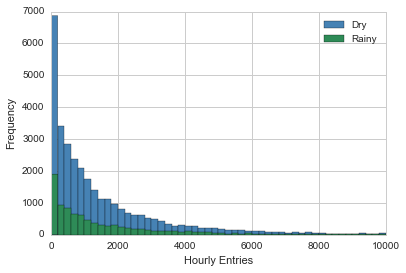

In [8]:
%matplotlib inline
nbins = 50
binrange = (0,10000)
plt.figure()
dry.hist(bins=nbins, range=binrange, label='Dry',color='steelblue')
rainy.hist(bins=nbins, range=binrange, label='Rainy',color='seagreen')
plt.legend()
plt.xlabel('Hourly Entries')
plt.ylabel('Frequency')
plt.show()

### Figure 1. Histogram of Hourly Entries on Days With Rain and Without Rain

<p>Figure 2 below shows the average NYC Subway ridership by day of week and rain conditions.</p>

On average there are 44.6792623754 more entries/hour on rainy days than dry days on a given day of the week.


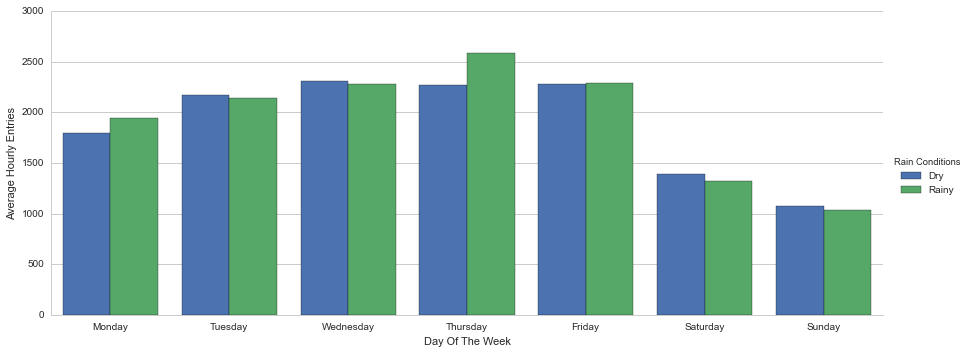

In [9]:
# Make the days of the week and rain conditions 'pretty' words
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
turnstile_weather['day_week_str'] = turnstile_weather['day_week']\
    .apply(lambda entry: (days[entry]))

rain_cond = ['Dry', 'Rainy']
turnstile_weather['Rain Conditions'] = turnstile_weather['rain']\
    .apply(lambda entry: (rain_cond[entry]))

    
# Group data by day of the week and rainy or dry conditions
entriesByDay = turnstile_weather[['day_week_str', 'ENTRIESn_hourly','Rain Conditions']]. \
    groupby(['day_week_str','Rain Conditions'], as_index=False).mean()

# Find the average difference in entries/hour for a given day of the week
dry2 = entriesByDay[entriesByDay['Rain Conditions']=='Dry'].ENTRIESn_hourly.mean()
rainy2 = entriesByDay[entriesByDay['Rain Conditions']=='Rainy'].ENTRIESn_hourly.mean()
rainy_dry_mean = rainy2 - dry2

print 'On average there are', rainy_dry_mean, 'more entries/hour on rainy days than dry days', \
    'on a given day of the week.'

plot2 = sns.factorplot('day_week_str', 'ENTRIESn_hourly','Rain Conditions', data=entriesByDay, kind="bar", \
    x_order=days, aspect=2.5)
plot2.set_ylabels(label='Average Hourly Entries')
plot2.set_xlabels(label='Day Of The Week')
plt.show()

### Figure 2. Average Hourly Entries By Day and Rain Condition

<p>Figure 3 below shows the histogram of entries/hour residuals from the linear model.</p>

On average, the residuals on rainy and dry days are:
Rain Conditions
Dry      3.189943e-11
Rainy    5.616720e-11
Name: residuals, dtype: float64


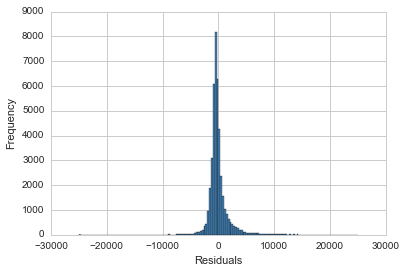

In [10]:
entriesRes = turnstile_weather[['ENTRIESn_hourly','Rain Conditions']]
entriesRes.is_copy = False

# Predict entries/hour using selected features and calculate the residuals
predicted_entries = clf.predict(picked_featuresdf)
residuals = hourly_entries - predicted_entries
entriesRes['residuals'] = residuals
entriesRes['predicted'] = predicted_entries

# Check difference on residuals due to rain conditions
res_group = entriesRes.groupby('Rain Conditions').residuals
print 'On average, the residuals on rainy and dry days are:'
print res_group.mean()

nbins = 150
binrange = (-25000,25000)
plt.figure()
residuals.hist(bins=nbins, range=binrange, color='steelblue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('')
plt.show()

### Figure 3. Histogram of Linear Model Residuals 

<p>Figure 4 below shows the entries/hour residuals from the linear model described in Section 2 plotted against the predicted'ENTRIESn_hourly' data.</p>

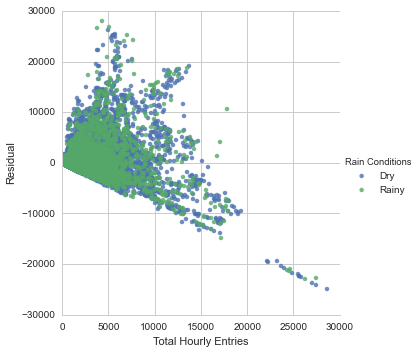

In [11]:
plot3 = sns.lmplot('predicted','residuals',hue='Rain Conditions', data=entriesRes, fit_reg=False,size=5, aspect=1)
plot3.set_ylabels(label='Residual')
plot3.set_xlabels(label='Total Hourly Entries')
plt.ylim(-30000,30000)
plt.xlim(0,30000)
plt.show()

###Figure 4. Hourly Entry Residuals from the Linear Model Described in Section 2.

<p>Figure 5 below shows the temporal plot of residuals from the linear model.

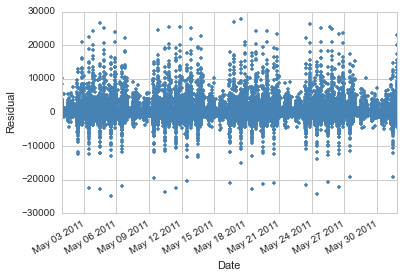

In [12]:
fig, ax = plt.subplots()
plt.plot_date(x=turnstile_weather['datetime'], y=residuals, fmt='.', color='steelblue')
fig.autofmt_xdate()

plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

###Figure 5. Temporal Plot of Residuals from the Linear Model 

## Section 4. Conclusions

### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

<p>The interpretation of the analysis done in the previous sections is that more people ride the NYC subway when it is raining than when it is not raining.</p>

### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis. 

<p>The P value from Mann-Whitney U test helps conclude that rain does have an affect on NYC subway ridership. On average, there are 182.7 more entries/hour on rainy days than on dry days. Additionally, when the linear regression model did not account for the 'rain' feature, the model overpredicted dry days (negative residual) and underestimated rainy days. The model that includes the 'rain' feature has a coefficient of 14.7. So on rainy days, there are an additional 14.7 entries/hour.</p>

## Section 5. Reflection

### 5.1. Please discuss potential shortcomings of the methods of your analysis, including dataset, analysis, such as the linear regression model or statistical test.

<p>Analysis improvements may include:
<ul>
<li>Assessing the quality of the dataset more thoroughly,</li>
<li>Examining outliers more closely,</li>
<li>Splitting data into training and test sets to possibly account for more features without the worry of overfitting,</li>
<li>Mapping scalar variables to ordinal variables to increase the number of features explored,</li>
<li>Transforming features or creating more features with the available features,and</li>
<li>Creating a nonlinear modelt that accounts for a diunral cycle.</li></ul></p>
<p>Dataset issues include:
<ul><li>Important features other than weather are not included,</li>
<li>Data may not cover a long enough time span since it only covers May 2011.</li>
<li>The sample may also not be representative since it only included 10 rainy days.
<li>The sum of rainy days and dry days was not the same as the total number of days.
</ul></p>